[*********************100%%**********************]  1 of 1 completed


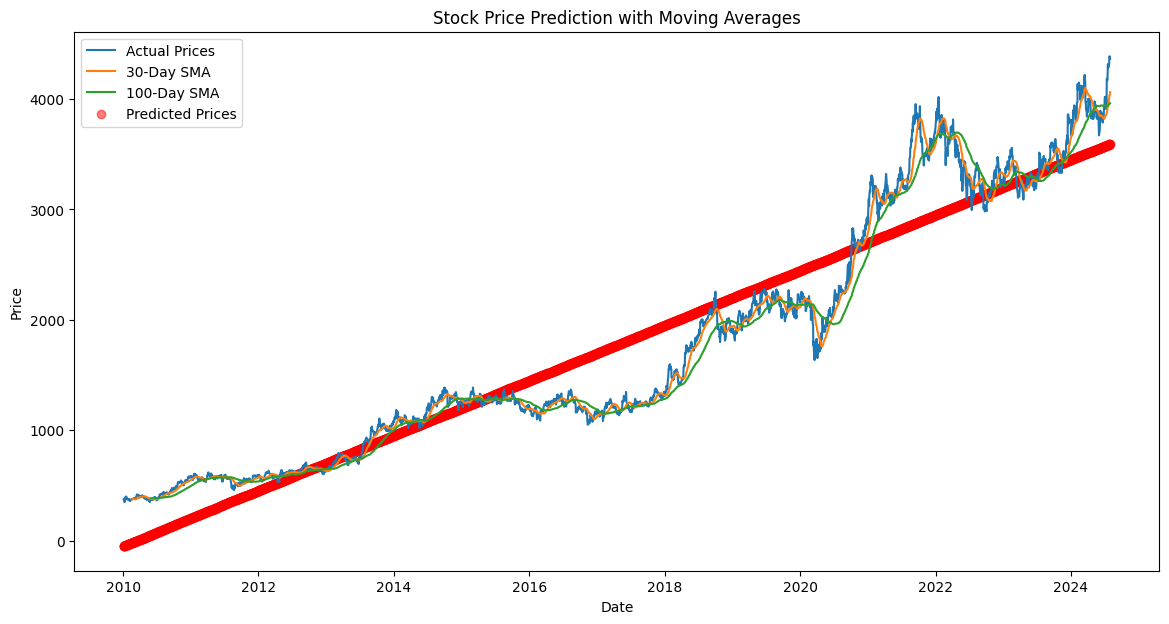

[*********************100%%**********************]  1 of 1 completed

Recommendation for TCS.NS: Investment Recommendation: Sell with 50.00% confidence, RMSE of model: 344.64.


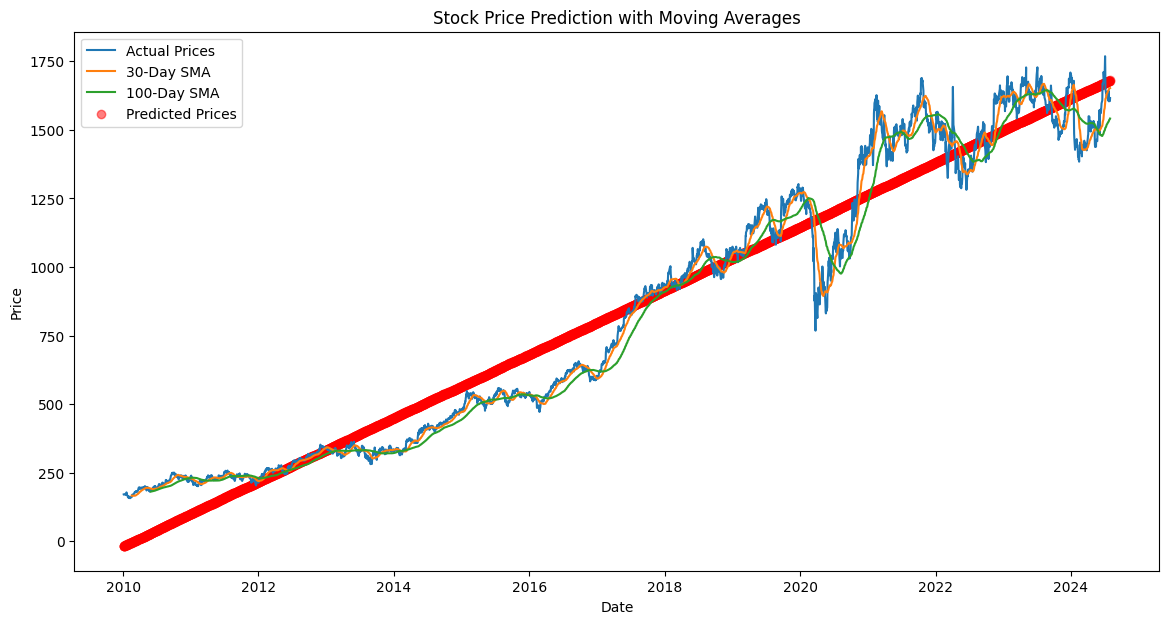

[*********************100%%**********************]  1 of 1 completed

Recommendation for HDFCBANK.NS: Investment Recommendation: Sell with 50.00% confidence, RMSE of model: 117.15.


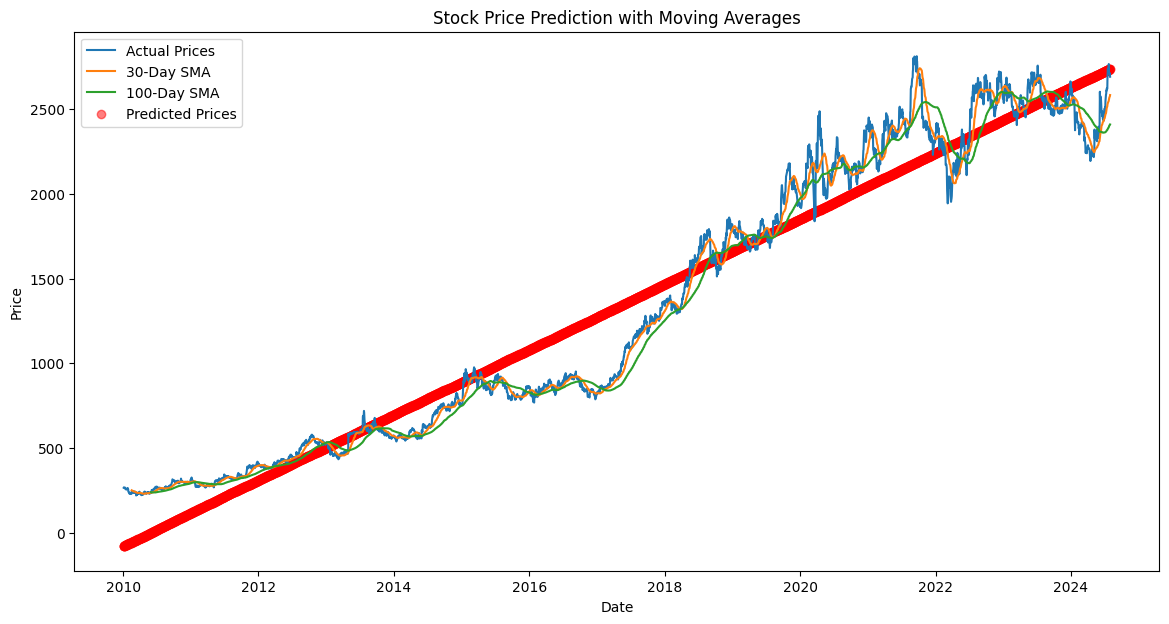

[*********************100%%**********************]  1 of 1 completed

Recommendation for HINDUNILVR.NS: Investment Recommendation: Sell with 50.00% confidence, RMSE of model: 200.30.


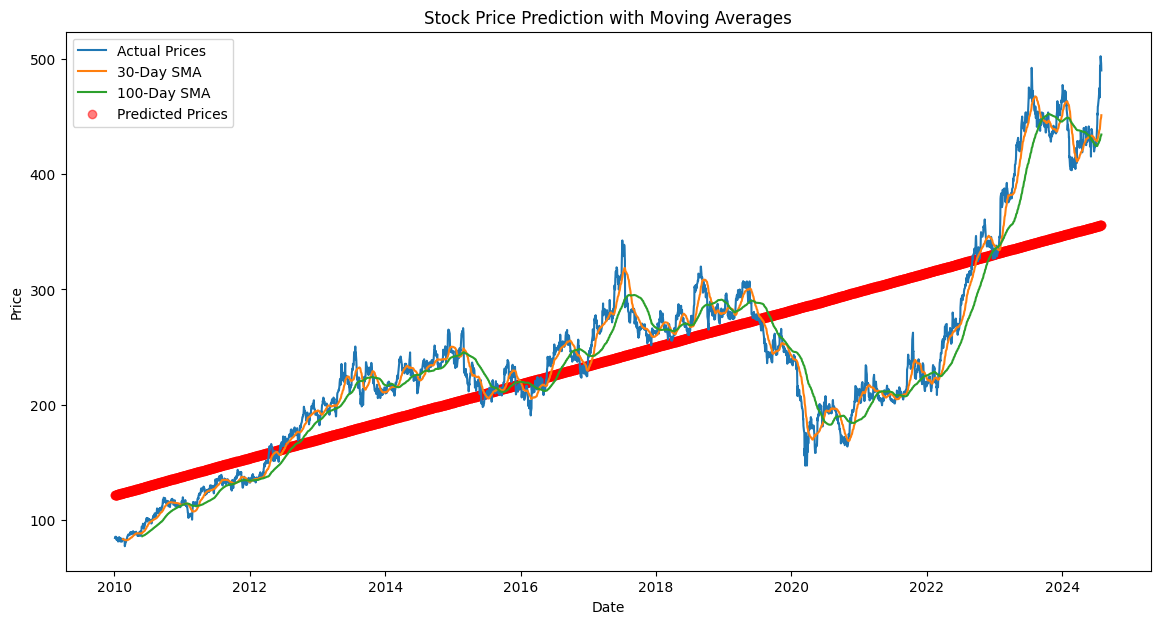

Recommendation for ITC.NS: Investment Recommendation: Sell with 50.00% confidence, RMSE of model: 55.75.


In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
import datetime  # Import datetime module

def fetch_data(ticker):
    """
    Fetch historical stock data and financials from Yahoo Finance.
    """
    end_date = datetime.datetime.now().strftime('%Y-%m-%d')
    try:
        data = yf.download(ticker, start="2010-01-01", end=end_date)
        if data.empty:
            raise ValueError(f"No data found for {ticker}")
        data['SMA_30'] = data['Close'].rolling(window=30).mean()
        data['SMA_100'] = data['Close'].rolling(window=100).mean()
        # Fetch financial data
        stock = yf.Ticker(ticker)
        balance_sheet = stock.balance_sheet
        return data, balance_sheet
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")
        return None, None

def financial_analysis(balance_sheet):
    """
    Perform financial ratio analysis with error handling for missing keys.
    """
    if balance_sheet is None or balance_sheet.empty:
        print("Balance sheet data is missing or empty.")
        return np.nan, np.nan

    try:
        if 'Total Current Assets' in balance_sheet.index and 'Total Current Liabilities' in balance_sheet.index:
            current_assets = balance_sheet.loc['Total Current Assets']
            current_liabilities = balance_sheet.loc['Total Current Liabilities']
            # Ensure that we're handling Series, not individual numbers
            if isinstance(current_assets, pd.Series) and isinstance(current_liabilities, pd.Series):
                current_ratio = current_assets.div(current_liabilities).iloc[-1]
            else:
                current_ratio = current_assets / current_liabilities
        else:
            current_ratio = np.nan

        if 'Total Liab' in balance_sheet.index and 'Total Stockholder Equity' in balance_sheet.index:
            total_liabilities = balance_sheet.loc['Total Liab']
            total_equity = balance_sheet.loc['Total Stockholder Equity']
            if isinstance(total_liabilities, pd.Series) and isinstance(total_equity, pd.Series):
                debt_to_equity = total_liabilities.div(total_equity).iloc[-1]
            else:
                debt_to_equity = total_liabilities / total_equity
        else:
            debt_to_equity = np.nan

    except Exception as e:
        print(f"Error analyzing financial data: {e}")
        return np.nan, np.nan

    return current_ratio, debt_to_equity


def linear_regression_model(data):
    """
    Apply Linear Regression to predict future stock prices based on historical prices.
    """
    if data is None or data.empty:
        return None, None, None, float('nan')
    data.loc[:, 'Day'] = range(len(data))
    X = data[['Day']]
    y = data['Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = LinearRegression()
    model.fit(X_train, y_train)
    rmse = sqrt(mean_squared_error(y_test, model.predict(X_test)))
    return model, X, y, rmse

def plot_data(data, model, X, y):
    """
    Plot stock prices and moving averages.
    """
    if data is not None and not data.empty:
        plt.figure(figsize=(14, 7))
        plt.plot(data['Close'], label='Actual Prices')
        plt.plot(data['SMA_30'], label='30-Day SMA')
        plt.plot(data['SMA_100'], label='100-Day SMA')
        if model is not None:
            plt.scatter(X.index, model.predict(X), color='red', label='Predicted Prices', alpha=0.5)
        plt.title('Stock Price Prediction with Moving Averages')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

def investment_recommendation(model, current_ratio, debt_to_equity, rmse):
    """
    Generate an investment recommendation based on predictive model and financial health,
    with handling for missing financial data.
    """
    if model is None:
        return "Unable to generate recommendation due to insufficient data"
    slope = model.coef_[0] if model else 0
    financial_health_score = np.tanh(current_ratio) - np.tanh(debt_to_equity) if not np.isnan(current_ratio) and not np.isnan(debt_to_equity) else 0
    confidence = 100 * np.tanh(slope) * financial_health_score if financial_health_score else 50
    recommendation = "Buy" if confidence > 50 else "Sell"
    return f"Investment Recommendation: {recommendation} with {confidence:.2f}% confidence, RMSE of model: {rmse:.2f}."

def run_analysis(ticker):
    data, balance_sheet = fetch_data(ticker)
    if data is not None and not data.empty:
        current_ratio, debt_to_equity = financial_analysis(balance_sheet)
        model, X, y, rmse = linear_regression_model(data)
        plot_data(data, model, X, y)
        return investment_recommendation(model, current_ratio, debt_to_equity, rmse)
    else:
        return f"No data to analyze for {ticker}"

# Loop through each ticker in the list and print the analysis results
nifty_50_top_tickers = [
   'TCS.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS',
    'ITC.NS'
]

for ticker in nifty_50_top_tickers:
    recommendation = run_analysis(ticker)
    print(f"Recommendation for {ticker}: {recommendation}")


### Stock Price Prediction Analysis with Moving Averages

This Jupyter Notebook visualizes the stock price predictions alongside actual stock prices and moving averages. Below is a breakdown of the elements in the plot and their implications for investment strategies.

#### Elements in the Chart

1. **Actual Prices (Blue Line)**:
   - Represents the actual historical stock prices.
   - This line follows the real market value of the stock over time.

2. **30-Day SMA (Green Line)**:
   - The 30-day Simple Moving Average (SMA) smooths out price data by creating a constantly updated average price over the past 30 days.
   - It helps identify the trend direction and smoothens short-term fluctuations.

3. **100-Day SMA (Orange Line)**:
   - Similar to the 30-day SMA but calculated over 100 days.
   - Provides a broader view of the price trend and is less reactive to daily price changes, offering insights into the longer-term market sentiment.

4. **Predicted Prices (Red Dots)**:
   - These are the prices predicted by the linear regression model.
   - The line connecting these points (inferred as red) shows a general upward trend prediction by the model.

5. **Trend Line (Red Line)**:
   - This line appears to be a linear regression line that predicts a long-term increase in stock prices, suggesting a bullish long-term outlook according to the regression model.

#### Analysis of Prediction and Trend

- The **distance between the actual and predicted prices**, especially in periods of high volatility, like the sharp peak around early 2021, shows the model’s limitations in capturing sudden market movements or anomalies.
- The **red trend line** showing an upward trend might suggest optimism in the long-term market behavior according to the regression analysis.

#### Investment Recommendation

- **"Sell with 50.00% confidence"**:
  - This recommendation implies that the model does not find strong evidence to suggest a buy or hold position.
  - The 50% confidence is a threshold value likely chosen to indicate uncertainty or a neutral stance, especially given the incomplete financial data.
  
- **"RMSE of model: 138.35"**:
  - Indicates the Root Mean Square Error of the model’s predictions.
  - An RMSE of 138.35, depending on the price scale of the stock, might be considered high, suggesting significant deviation of predicted values from actual prices.

#### Note on Incomplete Financial Data

- **"Incomplete Financial Data Available"**:
  - Indicates that not all needed financial data could be fetched or certain key financial ratios couldn't be computed.
  - This limitation affects the confidence of any investment recommendation because comprehensive financial analysis requires complete data.

#### Conclusion

Given the model's high RMSE and the note about incomplete financial data, caution is recommended. The prediction of rising stock prices shown by the trend line should be interpreted with skepticism unless corroborated by more robust models and complete data. The investment recommendation to sell might be more about risk aversion in the face of uncertain or incomplete analysis rather than a strong bearish outlook.

For further analysis, incorporating additional data, perhaps including different models or more complete financial metrics, would be beneficial to refine your investment decision-making process.